# **Поиск частых наборов**
1. Разработайте программу, которая выполняет поиск частых наборов объектов в заданном наборе данных с помощью алгоритма Apriori (или одной из его модификаций). Список результирующих наборов должен содержать как наборы, так и значение поддержки для каждого набора. Параметрами программы являются набор, порог поддержки и способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).
2. Проведите эксперименты на наборе данных baskets.csv (сведения о покупках в супермаркете). В экспериментах варьируйте пороговое значение поддержки (например: 1%, 3%, 5%, 10%, 15%).
3. Выполните визуализацию результатов экспериментов в виде следующих диаграмм:

- сравнение быстродействия на фиксированном наборе данных при изменяемом пороге поддержки;
- количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.

Подключим используемые библиотеки.

In [1]:
import pandas as pd
import chardet
import time
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori

Загрузим набор данных и посмотрим на него.

In [2]:
filename = 'baskets.csv'
with open(filename, 'rb') as f:
    result = chardet.detect(f.read())

df = pd.read_csv(filename, encoding=result['encoding'])
df

,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
0,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,низкокалорийный йогурт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7496,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подготовим данные: уберём NaN-значения из строк, преобразуем каждую строку (корзину покупок) в список товаров и сохраним транзакции в виде списка списков. Создадим отсортированный список всех уникальный товаров, преобразуем список покупок в one-hot encoding, где столбцы -- уникальные товары, а в ячейках значения True означает, что товар присутствует в данной покупке.

Запутим алгоритм Apriori, который выполнит поиск частых наборов с порогом минимальной поддержки.

Если передан параметр sort_by='support', сортируем по убыванию поддержки. Если передан sort_by='lexical', сортируем по лексикографическому порядку.

В качестве возвращаемых значений будут найденные частые наборы.

In [3]:
def run_apriori(data, min_support, sort_by='support'):
    transactions = data.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
    unique_items = sorted(set(item for transaction in transactions for item in transaction))
    encoded_data = pd.DataFrame([[item in transaction for item in unique_items] for transaction in transactions],
                                columns=unique_items)

    frequent_itemsets = apriori(encoded_data, min_support=min_support, use_colnames=True)

    if sort_by == 'support':
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
    elif sort_by == 'lexical':
        frequent_itemsets = frequent_itemsets.sort_values(by='itemsets')

    return frequent_itemsets

Зададим минимальную поддержку (1%) -- процент транзакций, в которых должен встречаться набор товаров, чтобы считаться частым. Алгоритм Apriori используется для поиска частых наборов объектов в наборе данных. Его работа основана на принципе априорной связи, который утверждает, что если некоторый набор объектов является частым, то любое его подмножество также должно быть частым, что позволяет сокращать количество проверяемых комбинаций.

In [4]:
min_support = 0.01
itemsets = run_apriori(df, min_support, sort_by='support')

itemsets.head(10)

,support,itemsets
31,0.238267,(минеральная вода)
26,0.188000,(макароны)
73,0.179733,(яйца)
20,0.170933,(картофель-фри)
69,0.163867,(шоколад)
17,0.132000,(зеленый чай)
32,0.129600,(молоко)
9,0.098267,(говяжий фарш)
15,0.095333,(замороженные овощи)
5,0.095067,(блинчики)


Согласно полученному результату наиболее популярными товарами являются "минеральная вода", "макароны" и "яйца".

In [5]:
itemsets_2 = itemsets[itemsets['itemsets'].apply(lambda x: len(x)) == 2]
itemsets_2

,support,itemsets
185,0.061200,"(минеральная вода, макароны)"
213,0.052667,"(минеральная вода, шоколад)"
215,0.050933,"(яйца, минеральная вода)"
201,0.048000,"(молоко, минеральная вода)"
105,0.040933,"(говяжий фарш, минеральная вода)"
...,...,...
125,0.010267,"(торт, замороженные овощи)"
121,0.010133,"(низкокалорийный йогурт, замороженные овощи)"
237,0.010133,"(суп, шоколад)"
114,0.010000,"(замороженный смузи, замороженные овощи)"


In [6]:
itemsets_3 = itemsets[itemsets['itemsets'].apply(lambda x: len(x)) == 3]
itemsets_3

,support,itemsets
247,0.017200,"(говяжий фарш, минеральная вода, макароны)"
256,0.016400,"(минеральная вода, шоколад, макароны)"
254,0.016133,"(молоко, минеральная вода, макароны)"
257,0.015200,"(яйца, минеральная вода, макароны)"
260,0.014000,"(молоко, минеральная вода, шоколад)"
262,0.013467,"(яйца, минеральная вода, шоколад)"
261,0.013067,"(молоко, яйца, минеральная вода)"
251,0.012267,"(минеральная вода, макароны, замороженные овощи)"
246,0.011733,"(блинчики, минеральная вода, макароны)"
258,0.011200,"(молоко, шоколад, макароны)"


Составим график сравнения времени выполнения при изменении порога поддержки. На нем наблюдается резкое снижение времени выполнения при увеличении порога поддержки, после чего оно стабилизируется. Это говорит о том, что при увеличении порога поддержки, алгоритм Apriori работает быстрее, так как количество частых наборов для проверки уменьшается.

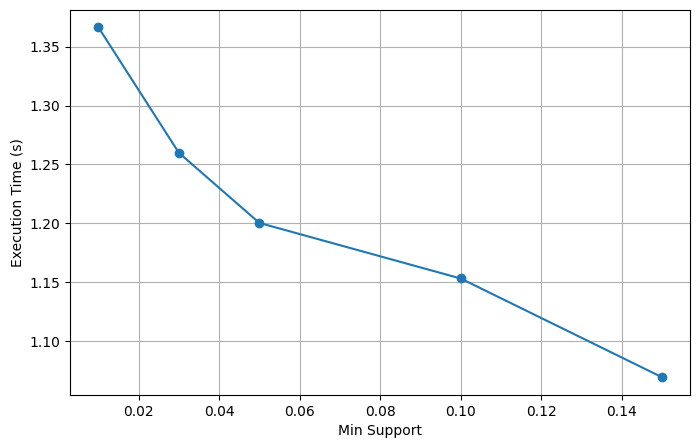

In [8]:
support_values = [0.01, 0.03, 0.05, 0.10, 0.15]
results = []

for support in support_values:
    start_time = time.time()
    itemsets = run_apriori(df, support)
    exec_time = time.time() - start_time
    results.append((support, exec_time, itemsets))

plt.figure(figsize=(8, 5))
plt.plot([r[0] for r in results], [r[1] for r in results], marker='o', linestyle='-')
plt.xlabel("Min Support")
plt.ylabel("Execution Time (s)")
plt.grid()
plt.show()

Построим график сравнения числа частых наборов разных длин при изменении порога поддержки. На нем видно, что с увеличение порога поддержи уменьшается число наборов и заметно уменьшение количества элементов в наборе.

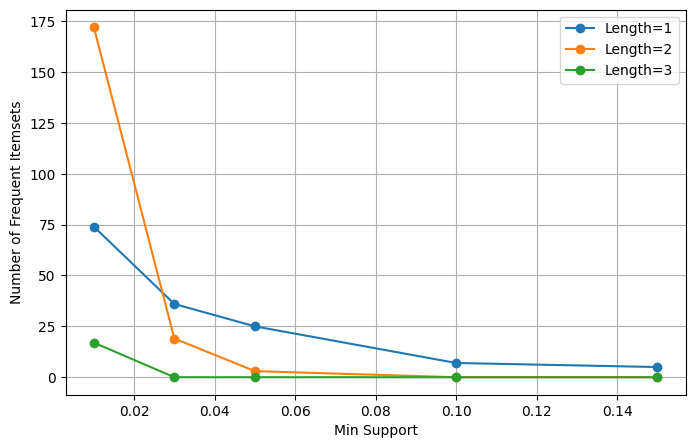

In [9]:
plt.figure(figsize=(8, 5))
supports = []
number_of_items_by_length = {}

for support, _, itemsets in results:
    itemset_lengths = itemsets['itemsets'].apply(len).value_counts().sort_index()
    supports.append(support)

    for length in range(1, max(itemset_lengths.index, default=0) + 1):
        if length not in number_of_items_by_length:
            number_of_items_by_length[length] = []
        number_of_items_by_length[length].append(itemset_lengths.get(length, 0))

for length in number_of_items_by_length:
    while len(number_of_items_by_length[length]) < len(supports):
        number_of_items_by_length[length].append(0)

for length, counts in number_of_items_by_length.items():
    plt.plot(supports, counts, marker='o', linestyle='-', label=f'Length={length}')

plt.xlabel("Min Support")
plt.ylabel("Number of Frequent Itemsets")
plt.legend()
plt.grid()
plt.show()